<hr/>

<hr/>

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install toad

     |████████████████████████████████| 14.8 MB 2.1 MB/s            
     |████████████████████████████████| 292 kB 62.9 MB/s            
     |████████████████████████████████| 2.0 MB 48.5 MB/s            
     |████████████████████████████████| 14.8 MB 42.0 MB/s            
     |████████████████████████████████| 14.8 MB 40.0 MB/s            
     |████████████████████████████████| 14.8 MB 51.5 MB/s            
     |████████████████████████████████| 14.8 MB 44.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.12
    Uninstalling Cython-0.29.12:
      Successfully uninstalled Cython-0.29.12
ERROR: pip's dependency resolver does not curren

## <span id="1"></span> ** 1. Overview **

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
from sklearn import datasets
from matplotlib import pyplot as plt
import toad
import jieba
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [450]:
import time
from sklearn.datasets import load_boston
dataset = pd.read_excel("/input/fxmonth/USD_JPY_Month.xlsx")
dataset.columns

Index(['Underlying', 'Type', 'Strike', 'Expiry', 'Notional', 'Curr', 'Premium',
       'Curr.1', 'Style', 'Code', 'Clr', 'Trd Time'],
      dtype='object')

In [451]:
d_min = pd.read_excel("/input/minute/USD_JPY_Minute.xlsx")
d_min.head()

Date      ER
0  2022-11-24T00:00:00.000Z  139.24
1  2022-11-23T23:59:00.000Z  139.24
2  2022-11-23T23:58:00.000Z  139.21
3  2022-11-23T23:57:00.000Z  139.27
4  2022-11-23T23:56:00.000Z  139.33

**Converts the string time to a unix timestamp**

In [452]:
def Changetime(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%m/%d/%Y %H:%M:%S'))*1000)
    except:
        print("**"+str1)
    return Unixtime


In [453]:
def Changetime1(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%Y-%m-%dT%H:%M:%S.000Z'))*1000)
    except:
        print("**"+str1)
    return Unixtime

Changetime1('2022-11-24T00:00:00.000Z')

1669248000000

per ms
1 1ms
1s 1000
1hour 3600000
1day 86400000
1week 604800000
1month 2629743000

In [454]:
dataset["Trd Time"] = dataset["Trd Time"].apply(Changetime)


In [455]:
d_min["ER"]

0        139.24
1        139.24
2        139.21
3        139.27
4        139.33
5        139.29
6        139.29
7        139.27
8        139.30
9        139.30
10       139.29
11       139.27
12       139.28
13       139.31
14       139.27
15       139.31
16       139.31
17       139.33
18       139.32
19       139.32
20       139.32
21       139.34
22       139.33
23       139.31
24       139.31
25       139.30
26       139.32
27       139.28
28       139.28
29       139.28
          ...  
38646    148.85
38647    148.86
38648    148.87
38649    148.88
38650    148.87
38651    148.90
38652    148.90
38653    148.90
38654    148.89
38655    148.88
38656    148.87
38657    148.88
38658    148.87
38659    148.85
38660    148.85
38661    148.85
38662    148.85
38663    148.87
38664    148.86
38665    148.88
38666    148.88
38667    148.90
38668    148.89
38669    148.90
38670    148.90
38671    148.93
38672    148.92
38673    148.91
38674    148.92
38675    148.91
Name: ER, Length: 38676,

In [456]:
d_min["Date"] = d_min["Date"].apply(Changetime1)

In [457]:
dataset.head()

Underlying Type      Strike    Expiry  Notional Curr  \
0  USD JPY Vanilla Option    C  141.000000  11/22/22  20000000  USD   
1  USD JPY Vanilla Option    C  141.000000  11/22/22  30000000  USD   
2  USD JPY Vanilla Option    C  139.080002  12/12/22   9000000  USD   
3  USD JPY Vanilla Option    C  139.080002  12/12/22  25000000  USD   
4  USD JPY Vanilla Option    C  139.080002  12/12/22   2000000  USD   

         Premium Curr.1 Style Code Clr       Trd Time  
0   32000.000000    USD    EU   TR   U  1668790325000  
1   48000.000000    USD    EU   TR   U  1668790301000  
2   99648.000000    USD    EU   TR   U  1668788137000  
3  276800.000000    USD    EU   TR   U  1668788118000  
4   22143.998047    USD    EU   TR   U  1668788118000

## <span id="2"></span> ** 2. data encoding **

In [458]:
dataset["Trd Time"].isnull().sum()
print(len(dataset["Trd Time"]))
print(dataset["Trd Time"][len(dataset["Trd Time"])-1])

4046
1666126941000


**find er after 1min / 30 min / 1 hour /1 day**

In [459]:
def find1min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10000 and (a-i)<10*60000):
            return j
    return -1
dataset["1min"] = dataset["Trd Time"].apply(find1min_er)
dataset["1min"].value_counts()

 148.82    70
 148.04    62
 146.22    40
 138.99    39
 147.08    32
 146.18    28
 148.79    27
 146.30    27
 148.26    26
 146.33    24
 149.16    21
-1.00      21
 149.18    20
 146.36    20
 148.29    19
 139.70    19
 148.85    19
 147.12    18
 139.88    18
 147.86    18
 146.53    17
 139.44    17
 146.40    17
 149.74    17
 148.20    17
 148.09    17
 146.39    16
 149.69    16
 147.31    16
 148.90    16
           ..
 150.87     1
 141.13     1
 150.65     1
 150.23     1
 143.53     1
 150.18     1
 141.00     1
 140.66     1
 150.42     1
 140.28     1
 148.72     1
 149.54     1
 150.14     1
 150.09     1
 138.91     1
 141.09     1
 149.13     1
 142.13     1
 142.31     1
 140.45     1
 143.69     1
 151.77     1
 141.57     1
 140.16     1
 147.40     1
 140.67     1
 145.52     1
 149.55     1
 141.99     1
 150.81     1
Name: 1min, Length: 784, dtype: int64

In [460]:
def find30min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10*60000 and (a-i)<50*60000):
            return j
    return -1
dataset["30min"] = dataset["Trd Time"].apply(find1min_er)
dataset["30min"].value_counts()

 148.82    70
 148.04    62
 146.22    40
 138.99    39
 147.08    32
 146.18    28
 148.79    27
 146.30    27
 148.26    26
 146.33    24
 149.16    21
-1.00      21
 149.18    20
 146.36    20
 148.29    19
 139.70    19
 148.85    19
 147.12    18
 139.88    18
 147.86    18
 146.53    17
 139.44    17
 146.40    17
 149.74    17
 148.20    17
 148.09    17
 146.39    16
 149.69    16
 147.31    16
 148.90    16
           ..
 150.87     1
 141.13     1
 150.65     1
 150.23     1
 143.53     1
 150.18     1
 141.00     1
 140.66     1
 150.42     1
 140.28     1
 148.72     1
 149.54     1
 150.14     1
 150.09     1
 138.91     1
 141.09     1
 149.13     1
 142.13     1
 142.31     1
 140.45     1
 143.69     1
 151.77     1
 141.57     1
 140.16     1
 147.40     1
 140.67     1
 145.52     1
 149.55     1
 141.99     1
 150.81     1
Name: 30min, Length: 784, dtype: int64

In [461]:
def find1h_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>60*60000 and (a-i)<120*60000):
            return j
    return -1
dataset["1h"] = dataset["Trd Time"].apply(find1min_er)
dataset["1h"].value_counts()

 148.82    70
 148.04    62
 146.22    40
 138.99    39
 147.08    32
 146.18    28
 148.79    27
 146.30    27
 148.26    26
 146.33    24
 149.16    21
-1.00      21
 149.18    20
 146.36    20
 148.29    19
 139.70    19
 148.85    19
 147.12    18
 139.88    18
 147.86    18
 146.53    17
 139.44    17
 146.40    17
 149.74    17
 148.20    17
 148.09    17
 146.39    16
 149.69    16
 147.31    16
 148.90    16
           ..
 150.87     1
 141.13     1
 150.65     1
 150.23     1
 143.53     1
 150.18     1
 141.00     1
 140.66     1
 150.42     1
 140.28     1
 148.72     1
 149.54     1
 150.14     1
 150.09     1
 138.91     1
 141.09     1
 149.13     1
 142.13     1
 142.31     1
 140.45     1
 143.69     1
 151.77     1
 141.57     1
 140.16     1
 147.40     1
 140.67     1
 145.52     1
 149.55     1
 141.99     1
 150.81     1
Name: 1h, Length: 784, dtype: int64

In [462]:
def find1d_er(a):
    for i,j in zip(d_min['Date'], d_min['EUR=']):
        if((a-i)>24*60*60000 and (a-i)<48*60*60000):
            return j
    return -1
dataset["1d"] = dataset["Trd Time"].apply(find1min_er)
dataset["1d"].value_counts()

 148.82    70
 148.04    62
 146.22    40
 138.99    39
 147.08    32
 146.18    28
 148.79    27
 146.30    27
 148.26    26
 146.33    24
 149.16    21
-1.00      21
 149.18    20
 146.36    20
 148.29    19
 139.70    19
 148.85    19
 147.12    18
 139.88    18
 147.86    18
 146.53    17
 139.44    17
 146.40    17
 149.74    17
 148.20    17
 148.09    17
 146.39    16
 149.69    16
 147.31    16
 148.90    16
           ..
 150.87     1
 141.13     1
 150.65     1
 150.23     1
 143.53     1
 150.18     1
 141.00     1
 140.66     1
 150.42     1
 140.28     1
 148.72     1
 149.54     1
 150.14     1
 150.09     1
 138.91     1
 141.09     1
 149.13     1
 142.13     1
 142.31     1
 140.45     1
 143.69     1
 151.77     1
 141.57     1
 140.16     1
 147.40     1
 140.67     1
 145.52     1
 149.55     1
 141.99     1
 150.81     1
Name: 1d, Length: 784, dtype: int64

In [463]:
dataset.head()

Underlying Type      Strike    Expiry  Notional Curr  \
0  USD JPY Vanilla Option    C  141.000000  11/22/22  20000000  USD   
1  USD JPY Vanilla Option    C  141.000000  11/22/22  30000000  USD   
2  USD JPY Vanilla Option    C  139.080002  12/12/22   9000000  USD   
3  USD JPY Vanilla Option    C  139.080002  12/12/22  25000000  USD   
4  USD JPY Vanilla Option    C  139.080002  12/12/22   2000000  USD   

         Premium Curr.1 Style Code Clr       Trd Time    1min   30min      1h  \
0   32000.000000    USD    EU   TR   U  1668790325000  140.11  140.11  140.11   
1   48000.000000    USD    EU   TR   U  1668790301000  140.11  140.11  140.11   
2   99648.000000    USD    EU   TR   U  1668788137000  139.88  139.88  139.88   
3  276800.000000    USD    EU   TR   U  1668788118000  139.88  139.88  139.88   
4   22143.998047    USD    EU   TR   U  1668788118000  139.88  139.88  139.88   

       1d  
0  140.11  
1  140.11  
2  139.88  
3  139.88  
4  139.88

In [464]:
def hotEncoding(NAME):
    value = dataset[NAME].value_counts()
    value_map = dict((v, i) for i,v in enumerate(value.index))
    dataset[NAME] = dataset.replace({NAME:value_map})[NAME]
hotEncoding('Underlying') 

In [465]:
def typecoding(NAME): 
    value1 = dataset[NAME].astype('category')
    dataset[NAME] = value1.cat.codes
typecoding('Curr')
typecoding('Type')
typecoding('Curr.1')
typecoding('Style')
typecoding('Code')
typecoding('Clr')
dataset['Underlying'] = dataset['Underlying'] +1
dataset['Type'] = dataset['Type'] +1
dataset['Curr'] = dataset['Curr'] +1
dataset['Curr.1'] = dataset['Curr.1'] +1
dataset.head()

Underlying  Type      Strike    Expiry  Notional  Curr        Premium  \
0           1     1  141.000000  11/22/22  20000000     1   32000.000000   
1           1     1  141.000000  11/22/22  30000000     1   48000.000000   
2           1     1  139.080002  12/12/22   9000000     1   99648.000000   
3           1     1  139.080002  12/12/22  25000000     1  276800.000000   
4           1     1  139.080002  12/12/22   2000000     1   22143.998047   

   Curr.1  Style  Code  Clr       Trd Time    1min   30min      1h      1d  
0       2      0     2    0  1668790325000  140.11  140.11  140.11  140.11  
1       2      0     2    0  1668790301000  140.11  140.11  140.11  140.11  
2       2      0     2    0  1668788137000  139.88  139.88  139.88  139.88  
3       2      0     2    0  1668788118000  139.88  139.88  139.88  139.88  
4       2      0     2    0  1668788118000  139.88  139.88  139.88  139.88

In [466]:
dataset = dataset.drop(['Expiry','Clr'], axis=1)
# dataset['toprice'] = dataset['Notional']/2+dataset['Premium']
# dataset['delrate'] = dataset['Premium']/(dataset['Curr']+1)
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
dataset.head()

Underlying  Type      Strike  Notional  Curr        Premium  Curr.1  Style  \
0           1     1  141.000000  20000000     1   32000.000000       2      0   
1           1     1  141.000000  30000000     1   48000.000000       2      0   
2           1     1  139.080002   9000000     1   99648.000000       2      0   
3           1     1  139.080002  25000000     1  276800.000000       2      0   
4           1     1  139.080002   2000000     1   22143.998047       2      0   

   Code       Trd Time    1min   30min      1h      1d  
0     2  1668790325000  140.11  140.11  140.11  140.11  
1     2  1668790301000  140.11  140.11  140.11  140.11  
2     2  1668788137000  139.88  139.88  139.88  139.88  
3     2  1668788118000  139.88  139.88  139.88  139.88  
4     2  1668788118000  139.88  139.88  139.88  139.88

## <span id="3"></span> ** 3. Data Analysis **

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [467]:
dataset= dataset.dropna()


### <span id="5"></span> ** using toad to perform exploratory data analysis and visualization**

In [468]:
dataset.isnull().sum()

Underlying    0
Type          0
Strike        0
Notional      0
Curr          0
Premium       0
Curr.1        0
Style         0
Code          0
Trd Time      0
1min          0
30min         0
1h            0
1d            0
dtype: int64

In [469]:
tance = toad.detector.detect(dataset)

In [470]:
tance

type  size missing  unique  mean_or_top1   std_or_top2  \
Underlying    int64  4046   0.00%       1  1.000000e+00  0.000000e+00   
Type           int8  4046   0.00%       1  1.000000e+00  0.000000e+00   
Strike      float64  4046   0.00%     832  1.463953e+02  2.080652e+02   
Notional      int64  4046   0.00%     155  3.725152e+07  5.034883e+07   
Curr           int8  4046   0.00%       1  1.000000e+00  0.000000e+00   
Premium     float64  4046   0.00%    2943  1.565630e+06  1.223323e+07   
Curr.1         int8  4046   0.00%       2  1.846268e+00  3.607363e-01   
Style          int8  4046   0.00%       1  0.000000e+00  0.000000e+00   
Code           int8  4046   0.00%       3  1.979486e+00  1.773987e-01   
Trd Time      int64  4046   0.00%    3099  1.667422e+12  8.234735e+08   
1min        float64  4046   0.00%     784  1.450314e+02  1.121374e+01   
30min       float64  4046   0.00%     784  1.450314e+02  1.121374e+01   
1h          float64  4046   0.00%     784  1.450314e+02  1.121374e+01   
1d          float64  4046   0.00%     784  1.450314e+02  1.121374e+01   

             min_or_top3    1%_or_top4   10%_or_top5  50%_or_bottom5  \
Underlying  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Type        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Strike      6.933850e-03  1.000000e+02  1.276458e+02    1.460000e+02   
Notional    1.000000e+04  1.000000e+04  2.000000e+05    2.000000e+07   
Curr        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Premium     0.000000e+00  0.000000e+00  2.465417e+04    3.183750e+05   
Curr.1      1.000000e+00  1.000000e+00  1.000000e+00    2.000000e+00   
Style       0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
Code        0.000000e+00  1.000000e+00  2.000000e+00    2.000000e+00   
Trd Time    1.666127e+12  1.666148e+12  1.666310e+12    1.667397e+12   
1min       -1.000000e+00  1.386415e+02  1.394800e+02    1.469250e+02   
30min      -1.000000e+00  1.386415e+02  1.394800e+02    1.469250e+02   
1h         -1.000000e+00  1.386415e+02  1.394800e+02    1.469250e+02   
1d         -1.000000e+00  1.386415e+02  1.394800e+02    1.469250e+02   

            75%_or_bottom4  90%_or_bottom3  99%_or_bottom2  max_or_bottom1  
Underlying    1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Type          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Strike        1.500000e+02    1.530500e+02    1.625000e+02    1.335500e+04  
Notional      5.000000e+07    1.000000e+08    2.500000e+08    2.500000e+08  
Curr          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Premium       8.200000e+05    1.999512e+06    2.872350e+07    6.077075e+08  
Curr.1        2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Style         0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
Code          2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Trd Time      1.668126e+12    1.668557e+12    1.668763e+12    1.668790e+12  
1min          1.487400e+02    1.498000e+02    1.514900e+02    1.518700e+02  
30min         1.487400e+02    1.498000e+02    1.514900e+02    1.518700e+02  
1h            1.487400e+02    1.498000e+02    1.514900e+02    1.518700e+02  
1d            1.487400e+02    1.498000e+02    1.514900e+02    1.518700e+02

## <span id="3"></span> 1. 1min model 

In [471]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2832, 2)
Shape of X_test:  (1214, 2)
Shape of y_train:  (2832,)
Shape of y_test (1214,)


In [472]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.023255066010847602
R2_score (train):  0.00010832341892330621
R2_score (test):  0.00020496537051584163
RMSE:  11.724995618114084


In [473]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.0400007974106503
R2_score (train):  -0.02827810481847326
R2_score (test):  -0.029498422940092306
RMSE:  11.897892595355708


In [474]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [475]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -3.2132506475291427
R2_score (train):  0.9959438174445716
R2_score (test):  -0.9953747230440928
RMSE:  16.564160671885997


In [476]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.702556970844085
R2_score (train):  0.8195938284203506
R2_score (test):  -0.26595487518914585
RMSE:  13.193691168193151


In [477]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model       RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  11.724996            0.000108        0.000205         -0.023255
1   SVM  11.897893           -0.028278        0.029498         -0.040001
2   KNN  16.564161            0.995944        0.995375          3.213251
3    RF  13.193691            0.819594        0.265955          0.702557

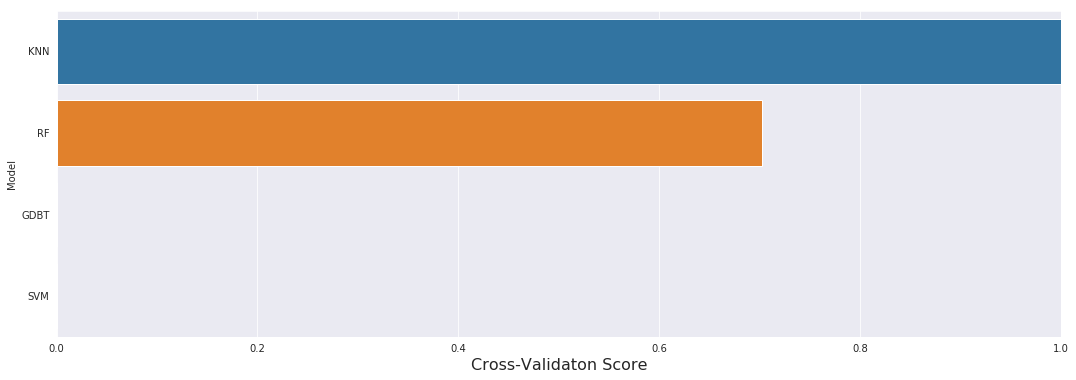

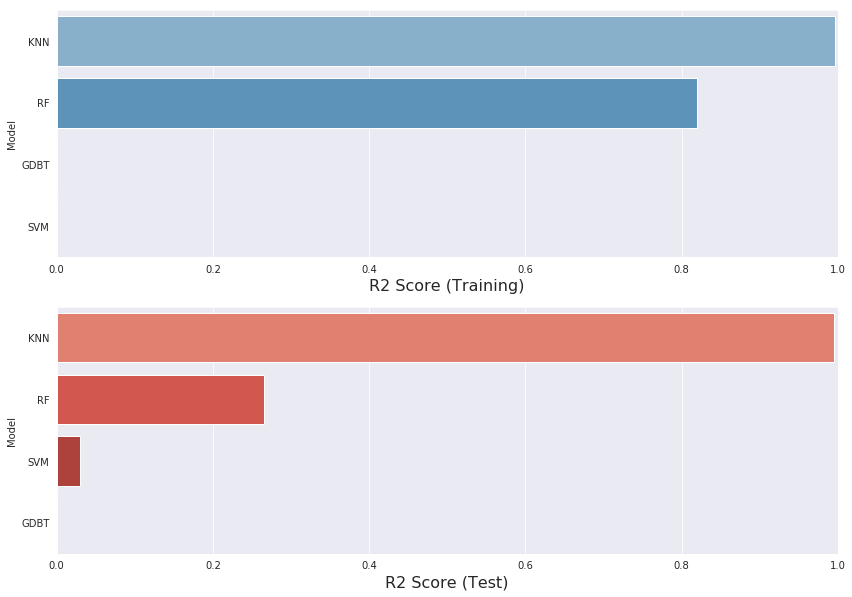

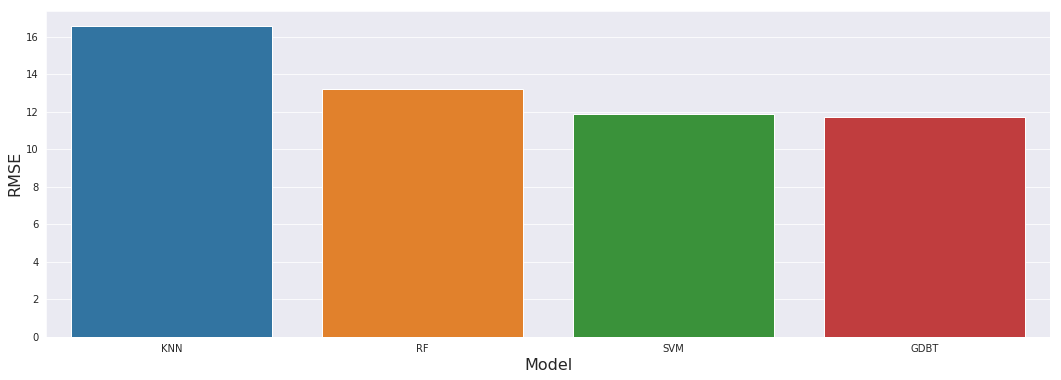

In [478]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 2. 30min model 

In [479]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,11]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2832, 2)
Shape of X_test:  (1214, 2)
Shape of y_train:  (2832,)
Shape of y_test (1214,)


In [480]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.023255066010847602
R2_score (train):  0.00010832341892330621
R2_score (test):  0.00020496537051584163
RMSE:  11.724995618114084


In [481]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.0400007974106503
R2_score (train):  -0.02827810481847326
R2_score (test):  -0.029498422940092306
RMSE:  11.897892595355708


In [482]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [483]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -3.2132506475291427
R2_score (train):  0.9959438174445716
R2_score (test):  -0.9953747230440928
RMSE:  16.564160671885997


In [484]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.702556970844085
R2_score (train):  0.8195938284203506
R2_score (test):  -0.26595487518914585
RMSE:  13.193691168193151


In [485]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model       RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  11.724996            0.000108        0.000205         -0.023255
1   SVM  11.897893           -0.028278        0.029498         -0.040001
2   KNN  16.564161            0.995944        0.995375          3.213251
3    RF  13.193691            0.819594        0.265955          0.702557

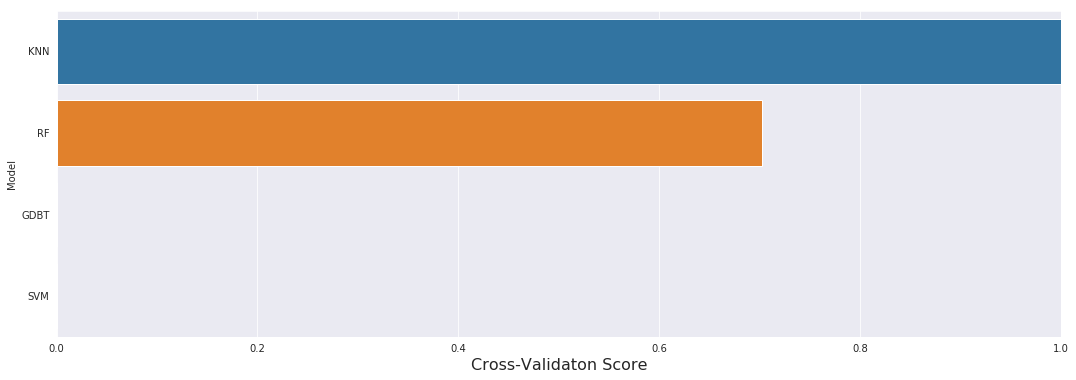

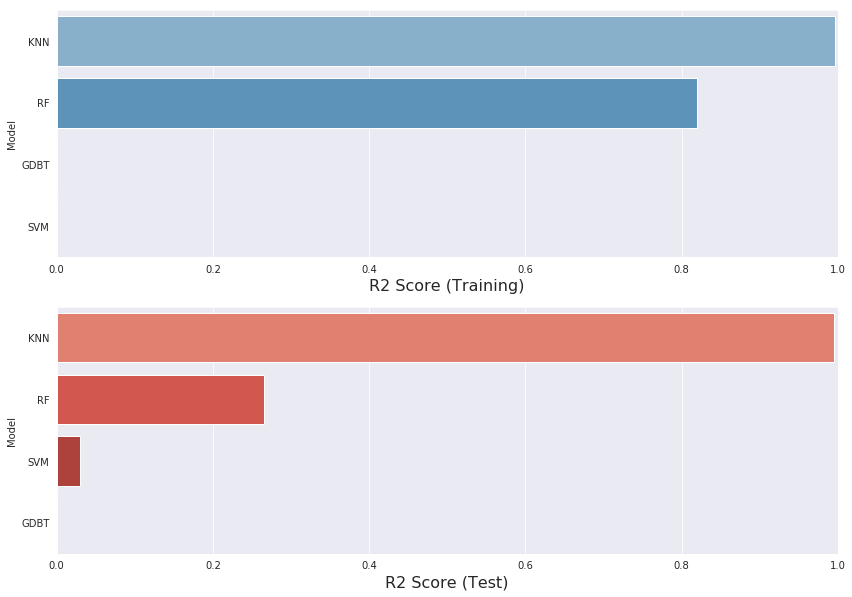

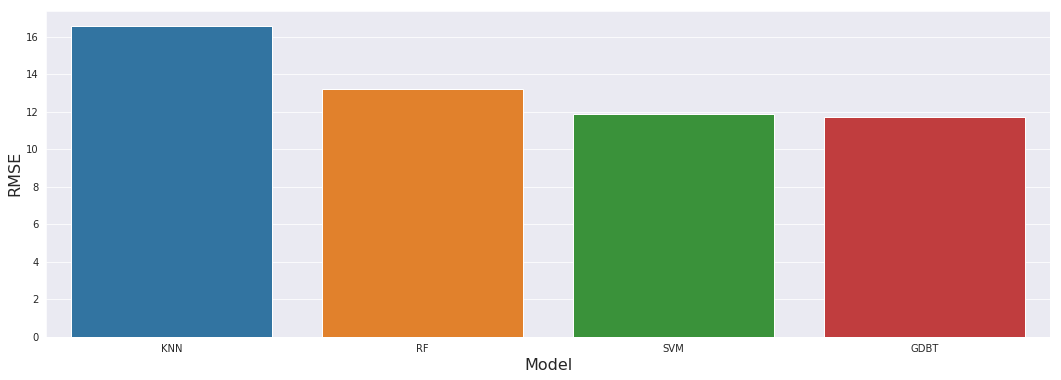

In [486]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 3. 1hour model 

In [487]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2832, 2)
Shape of X_test:  (1214, 2)
Shape of y_train:  (2832,)
Shape of y_test (1214,)


In [488]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.023255066010847602
R2_score (train):  0.00010832341892330621
R2_score (test):  0.00020496537051584163
RMSE:  11.724995618114084


In [489]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.0400007974106503
R2_score (train):  -0.02827810481847326
R2_score (test):  -0.029498422940092306
RMSE:  11.897892595355708


In [490]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [491]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -3.2132506475291427
R2_score (train):  0.9959438174445716
R2_score (test):  -0.9953747230440928
RMSE:  16.564160671885997


In [492]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.702556970844085
R2_score (train):  0.8195938284203506
R2_score (test):  -0.26595487518914585
RMSE:  13.193691168193151


In [493]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model       RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  11.724996            0.000108        0.000205         -0.023255
1   SVM  11.897893           -0.028278        0.029498         -0.040001
2   KNN  16.564161            0.995944        0.995375          3.213251
3    RF  13.193691            0.819594        0.265955          0.702557

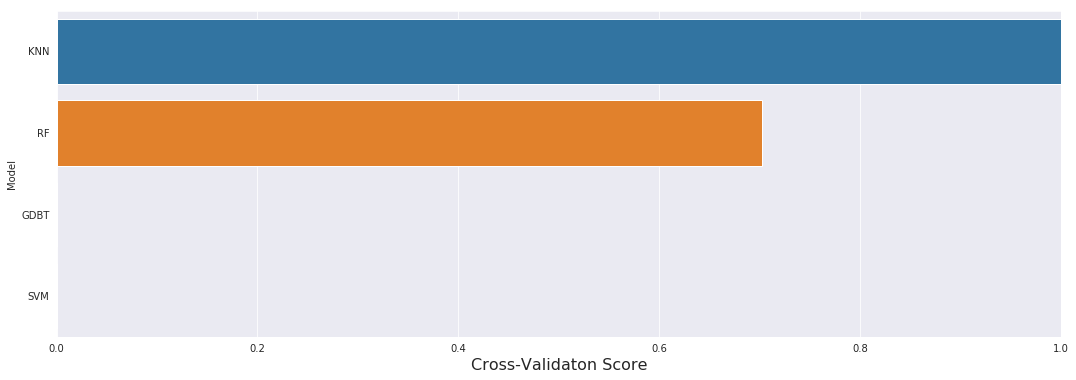

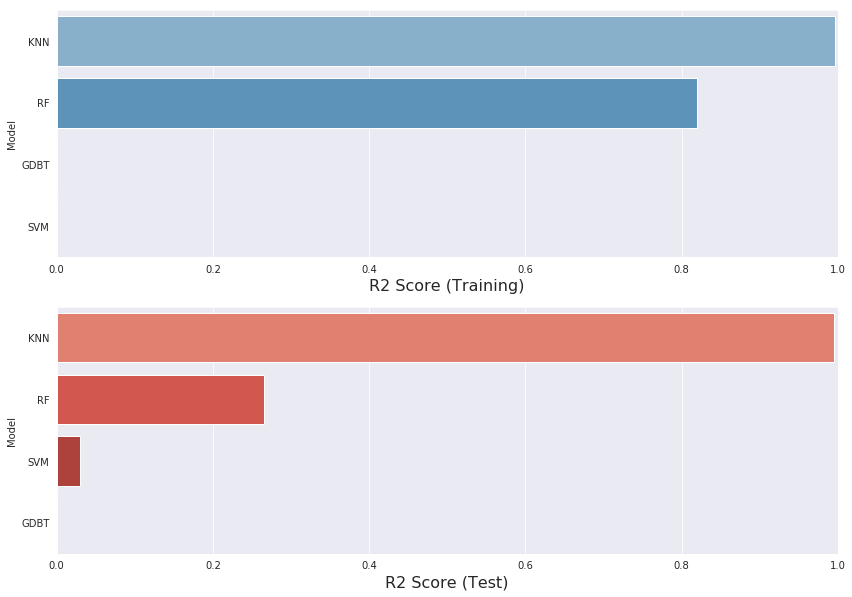

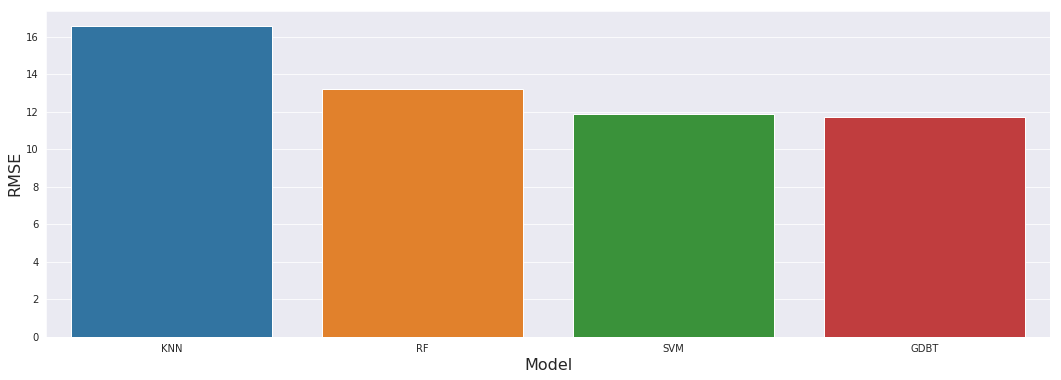

In [494]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 1. 1day model 

In [495]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2832, 2)
Shape of X_test:  (1214, 2)
Shape of y_train:  (2832,)
Shape of y_test (1214,)


In [496]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.023255066010847602
R2_score (train):  0.00010832341892330621
R2_score (test):  0.00020496537051584163
RMSE:  11.724995618114084


In [497]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.0400007974106503
R2_score (train):  -0.02827810481847326
R2_score (test):  -0.029498422940092306
RMSE:  11.897892595355708


In [498]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [499]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -3.2132506475291427
R2_score (train):  0.9959438174445716
R2_score (test):  -0.9953747230440928
RMSE:  16.564160671885997


In [500]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.702556970844085
R2_score (train):  0.8195938284203506
R2_score (test):  -0.26595487518914585
RMSE:  13.193691168193151


In [501]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model       RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  11.724996            0.000108        0.000205         -0.023255
1   SVM  11.897893           -0.028278        0.029498         -0.040001
2   KNN  16.564161            0.995944        0.995375          3.213251
3    RF  13.193691            0.819594        0.265955          0.702557

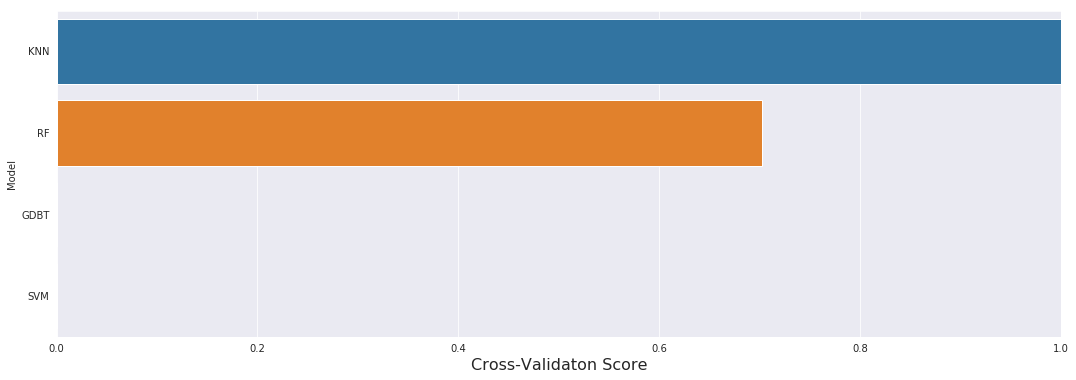

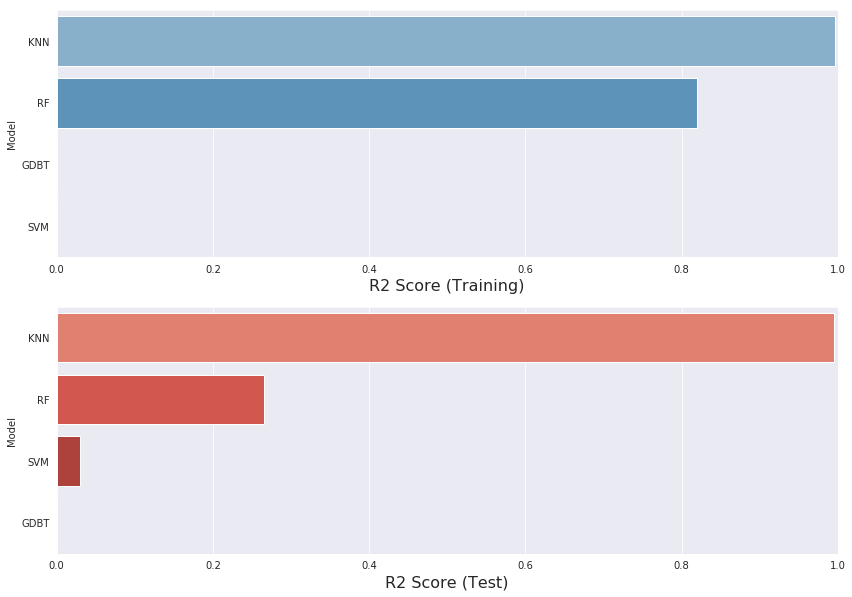

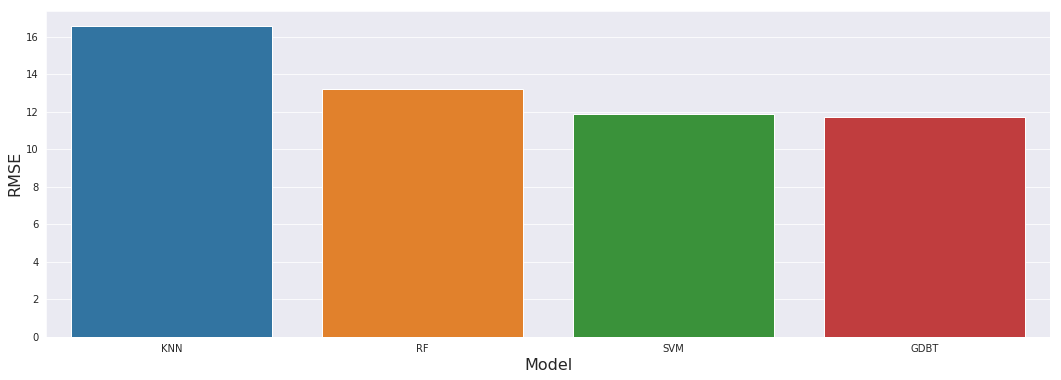

In [502]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

------------

**origin **

------------

In [ ]:
y = dataset.iloc[:,5]
X = dataset.drop('Premium', axis=1).iloc[:,:]

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
dataset.head()

In [ ]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

### <span id="5"></span> ** Visualizing Data **

### <span id="5"></span> **Correlations can be found by thermal maps **

In [ ]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [ ]:
sns.pairplot(dataset)
plt.show()

## <span id="6"></span> ** 4. Regression Models **

### <span id="7"></span> ** gdbt **

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

### <span id="11"></span> ** SVM **

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#第五步：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression
print 'R-squared value of uniform-weighted KNR is',uni_knr.score(X_test,y_test)
print 'the MSE of uniform-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
print 'the MAE of uniform-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
#2.The prediction method is KNR according to the weighted distance
print 'R-squared value of distance-weighted KNR is',dis_knr.score(X_test,y_test)
print 'the MSE of distance-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))
print 'the MAE of distance-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

### <span id="13"></span> ** Random Forest Regression **

In [ ]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

## <span id="14"></span> ** 5. Measuring the Error **

In [ ]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

### <span id="15"></span> ** Visualizing Model Performance **

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

In [ ]:
predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="16"></span> ** 6. Conclusion **